In [ ]:
import numpy as np
import time
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 

import tensorflow as tf
from Plots import plot_action_profit_percent
from Dataset import BitcoinData
from TradingEnvironment import TradingEnvironment
from Models import DoubleDQN

from keras.models import load_model

tf.keras.utils.disable_interactive_logging()

NUM_EPISODES = 5
NUM_EPISODES_TEST = 1

MODEL_DQN = 0
MODEL_DOUBLE_DQN = 1
MODEL_DUELING_DQN = 2

In [ ]:
def get_environment(start_time=0):
    bitcoin_data = BitcoinData()

    return TradingEnvironment(bitcoin_data, start_time=start_time)

def get_agent(environment, model_type, load_version=-1, load_model_num=-1):
    observation_space = environment.get_observation_space()
    action_space = environment.get_action_space()

    if model_type == MODEL_DOUBLE_DQN:
        return DoubleDQN(observation_space, action_space, model_path="DoubleDQN", 
                         load_version=load_version, load_model_num=load_model_num)    
    return None

def cryptocurrencies_trading(agent, environment, train=True):
    observation_space = environment.get_observation_space()
    episode = 0

    while episode < NUM_EPISODES:
        episode += 1
        state = environment.reset()
        step = 0
        while True:
            step += 1
            action = agent.act(np.reshape(state, [1, observation_space]))
            next_state, reward, done, info = environment.step(action - 1)

            if train:
                agent.memory.remember(state, action, reward, next_state, done)
                agent.learn()

            state = next_state

            if done:
                print("Episode: {}/{}, profit: {:.4f}, min_profit: {:.4}, max_profit: {:.4}".format(
                    episode, NUM_EPISODES, environment.percent_profit, environment.min_percent_profit, environment.max_percent_profit))
                break

            if (step - 1) % 100 == 0:
                print("Step: {}, profit: {:.4f}, min_profit: {:.4f}, max_profit: {:.4f}".format(
                    step - 1, environment.percent_profit, environment.min_percent_profit, environment.max_percent_profit))

        if train: 
            agent.save_model()


In [ ]:
environment = get_environment()
agent = get_agent(environment, MODEL_DOUBLE_DQN)

cryptocurrencies_trading(agent, environment)

In [ ]:
last_episode = 13
start_time = TradingEnvironment.NUM_OBSERVATIONS * last_episode
load_version = 1
load_model_num = -1

environment = get_environment(start_time=start_time)
#agent = get_agent(environment, MODEL_DOUBLE_DQN, load_version=load_version, load_model_num=load_model_num)
agent.exploration_rate = 0.0

cryptocurrencies_trading(agent, environment, train=False)

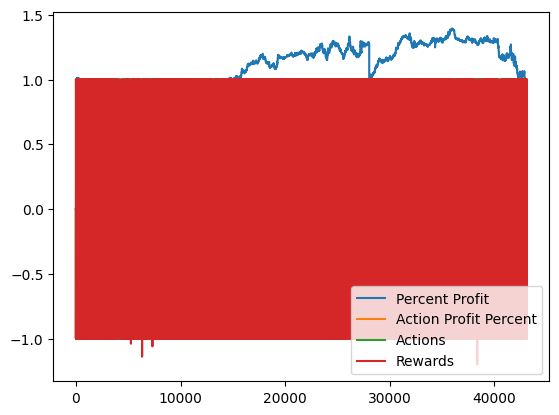

In [4]:
plot_action_profit_percent(agent.memory.states, agent.memory.actions, agent.memory.rewards, agent.memory.dones)